# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [10]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

#  [2] Exploratory Data Analysis

We already done EDA and prepossing of data and stored it in final.sqlite. This we will use it directly so now we don't need to do EDA and preprocessing. In Preprocessing section, we are going to use our saved final.sqlite directly.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
#loading preprocessed data which was stored in final dataset
con = sqlite3.connect('final.sqlite') 

In [12]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape

(364171, 12)

In [13]:
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [14]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [15]:
# To randomly sample 100k points from both class
random_sample_data = cleaned_data.sample(n=100000) 
random_sample_data.shape

(100000, 12)

In [16]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)
final_sorted_time.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...


In [17]:
#data splitting
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(49000,)
(21000,)
(30000,)


In [18]:
train_data=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
test_data=final_sorted_time['CleanedText'][70000:100000]
print(train_data.shape)
print(cv_data.shape)
print(y_test.shape)

(49000,)
(21000,)
(30000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [19]:
count_vector = CountVectorizer()
bow_train = count_vector.fit_transform(train_data)
bow_cv  = count_vector.transform(cv_data)
bow_test= count_vector.transform(test_data)

In [20]:
print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(49000, 27148)
(21000, 27148)
(30000, 27148)


In [21]:
np.save("bow_train", bow_train)
np.save("bow_cv", bow_cv)
np.save("bow_test", bow_test)

## [4.2] TF-IDF

In [22]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(train_data)
tf_cv  = tfidf_vec.transform(cv_data)
tf_test = tfidf_vec.transform(test_data)

In [23]:
np.save("tf_train", tf_train)
np.save("tf_cv", tf_cv)
np.save("tf_test", tf_test)

## [4.3] Word2Vec

In [24]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [25]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [26]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [27]:
print(len(list_of_sent_train))
print(len(list_of_sent_cv))
len(list_of_sent_test)

49000
21000


30000

In [28]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9338
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'one', 'collect', 'fill', 'comedi', 'action', 'whatev', 'els', 'want', 'call']


## [4.3.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.3.1.1] Avg W2v

In [30]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [31]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [32]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


In [33]:
avgw2v_train= np.array(sent_vectors_train)
avgw2v_cv= np.array(sent_vectors_cv)
avgw2v_test= np.array(sent_vectors_test)

In [35]:
np.save("avgw2v_train", avgw2v_train)
np.save("avgw2v_cv", avgw2v_cv)
np.save("avgw2v_test", avgw2v_test)

#### [4.3.1.2] TFIDF weighted W2v

In [36]:
tfidf_vector = TfidfVectorizer()
tfidf_train = tfidf_vector.fit_transform(train_data)
tf_idf_feat = tfidf_vector.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [37]:
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [38]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [39]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_cv= np.array(tfidf_sent_vec_cv)
tfw2v_test= np.array(tfidf_sent_vec_test)

In [40]:
np.save("tfw2v_train", tfw2v_train)
np.save("tfw2v_cv", tfw2v_cv)
np.save("tfw2v_test", tfw2v_test)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [44]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
bow_train1 = sc.fit_transform(bow_train)
bow_cv1 = sc.transform(bow_cv)
bow_test1 = sc.transform(bow_test)

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve

Hypertuning as follows:

In [56]:
list_C=[10** -4, 10**-3,10**-2,10**-1,1,10,100,1000,10000]
param = {'C' : list_C }
model_bow  =GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l1'),param , scoring = 'roc_auc',cv = 3, n_jobs= -1)
model_bow.fit(bow_train1,y_train)

print("AUC of Model", model_bow.score(bow_cv1, y_cv))
print("Model with best parameters :\n",model_bow.best_estimator_)
#Optimal value of C
optimal_C = model_bow.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C)

AUC of Model 0.9321881340391387
Model with best parameters :
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  0.01


# Graph representation of CV error v/s values of C on cv data of BOW with L1 as follows:

In [58]:
cv_errors = [1-i for i in model_bow.cv_results_['mean_test_score']]

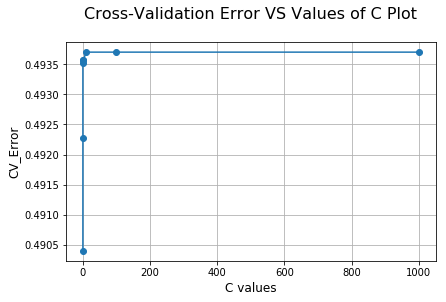

In [204]:
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of BOW with L1 as follows:

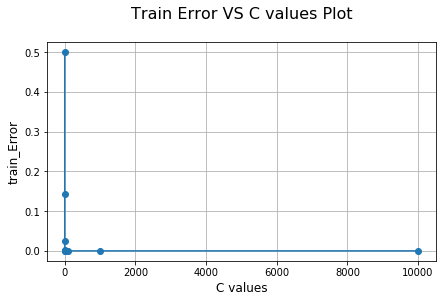

In [75]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_bow.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data as follows:

In [102]:
pred_train= model_bow.predict(bow_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 6438,   492],
       [ 3349, 38721]], dtype=int64)

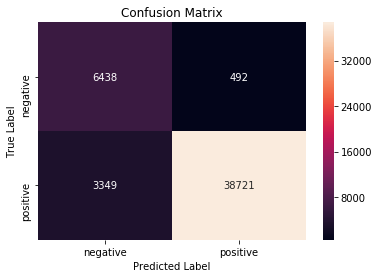

In [103]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test Data of BOW 

In [104]:
clf_bow = LogisticRegression(penalty = 'l1', C = 0.01,class_weight = 'balanced', n_jobs=-1)
clf_bow.fit(bow_train1, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## ROC Curve of train data and test data on BOW with L1 as follows:

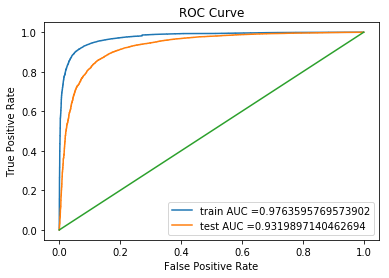

In [105]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_bow.predict_proba(bow_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_bow.predict_proba(bow_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [106]:
pred = clf_bow.predict(bow_test1)
pred_prob = clf_bow.predict_proba(bow_test1)[:,1]
pred_prob_train= clf_bow.predict_proba(bow_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.9763595769573902
AUC value on test data: 0.9319897140462694


### Confusion Matrix of Test data as follows:

In [107]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4260,   889],
       [ 2537, 22314]], dtype=int64)

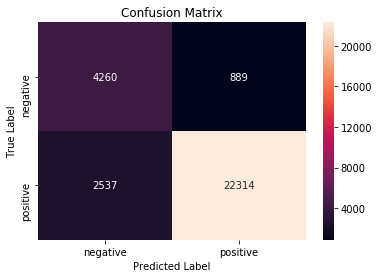

In [108]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [109]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.63      0.83      0.71      5149
          1       0.96      0.90      0.93     24851

avg / total       0.90      0.89      0.89     30000



#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [110]:
#lamda=1
clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced', n_jobs=-1)
clf.fit(bow_train1, y_train)
w = clf.coef_
print(np.count_nonzero(w))

9838


In [111]:
#lamda=10
clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced', n_jobs=-1)
clf.fit(bow_train1, y_train)
w = clf.coef_
print(np.count_nonzero(w))

8627


In [112]:
#lamda=100
clf = LogisticRegression(penalty = 'l1', C = 0.01,class_weight = 'balanced', n_jobs=-1)
clf.fit(bow_train1, y_train)
w = clf.coef_
print(np.count_nonzero(w))

3182


In [113]:
#lamda=1000
clf = LogisticRegression(penalty = 'l1', C = 0.001,class_weight = 'balanced', n_jobs=-1)
clf.fit(bow_train1, y_train)
w = clf.coef_
print(np.count_nonzero(w))

114


OBSERVATION :- From above we can see that the number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing). that means more sparsity by increasing lamda(decreasing C)

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

Hypertuning:

In [93]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_bow_l2=GridSearchCV(LogisticRegression(class_weight ='balanced',penalty='l2'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_bow_l2.fit(bow_train1,y_train)

print("AUC of Model", model_bow_l2.score(bow_cv1, y_cv))
print("Model with best parameters :\n",model_bow_l2.best_estimator_)
#Optimal value of C
optimal_C_bow_l2 = model_bow_l2.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_bow_l2)

AUC of Model 0.9206410003926399
Model with best parameters :
 LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  0.0001


# Graph representation of CV error v/s values of C on cv data of BOW with L2 as follows:

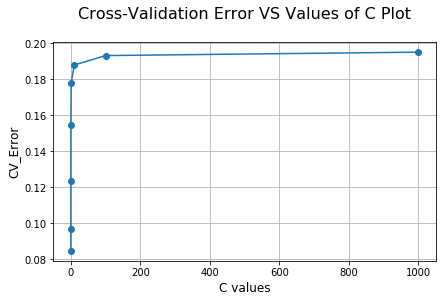

In [114]:
cv_errors = [1-i for i in model_bow_l2.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of BOW with L2 as follows:

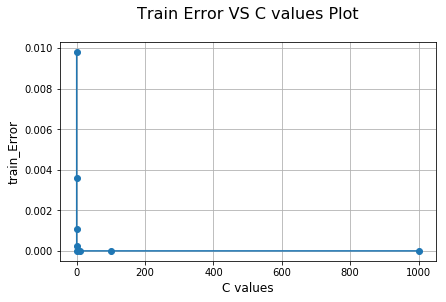

In [115]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_bow_l2.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [116]:
pred_train= model_bow_l2.predict(bow_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 6506,   424],
       [ 1868, 40202]], dtype=int64)

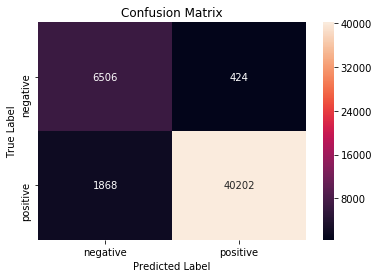

In [117]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on Test data of BOW with L2

In [118]:
clf_bow_l2 = LogisticRegression(penalty = 'l2', C = 0.0001,class_weight = 'balanced', n_jobs=-1)
clf_bow_l2.fit(bow_train1, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## ROC Curve of train data and test data on BOW with L2 as follows:

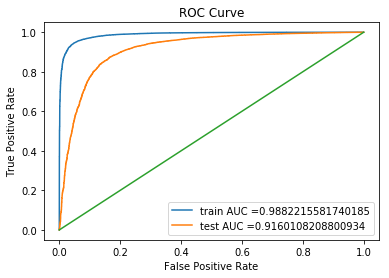

In [119]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_bow_l2.predict_proba(bow_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_bow_l2.predict_proba(bow_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [120]:
pred = clf_bow_l2.predict(bow_test1)
pred_prob = clf_bow_l2.predict_proba(bow_test1)[:,1]
pred_prob_train= clf_bow_l2.predict_proba(bow_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.9882215581740185
AUC value on test data: 0.9160108208800934


### Confusion Matrix of test data

In [121]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4005,  1144],
       [ 2184, 22667]], dtype=int64)

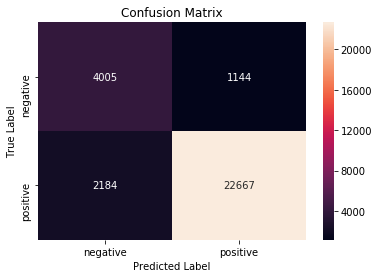

In [122]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [123]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.65      0.78      0.71      5149
          1       0.95      0.91      0.93     24851

avg / total       0.90      0.89      0.89     30000



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [126]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = clf_bow_l2.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = bow_train1.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = bow_train1.indices
indptr_X_train = bow_train1.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = bow_train1.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = bow_train1 + sparse_epsilon

print(bow_train1.shape)
print(epsilon_train.shape)

(49000, 27148)
(49000, 27148)


In [127]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=0.0001, n_jobs=-1)
epsilon_lr.fit(epsilon_train,y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.05242135, 0.04937718, 0.04020544, 0.03736073, 0.03359917,
       0.0328207 , 0.03052692, 0.02850071, 0.02812994, 0.02769624,
       0.02611108, 0.02537542, 0.02271279, 0.02270074, 0.02210336,
       0.0214304 , 0.02084994, 0.02058239, 0.0201501 , 0.020125  ])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of from<font color='red'> SET 1</font> with L2 Regularization

In [130]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vector.get_feature_names()
weight_values = clf_bow_l2.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.165311
  disappoint	--> 	-0.135962
        love	--> 	0.135302
        best	--> 	0.119928
      delici	--> 	0.092360
        good	--> 	0.081581
     perfect	--> 	0.080755
       worst	--> 	-0.080472
       excel	--> 	0.078765
         bad	--> 	-0.074469


#### [5.1.3.2] Top 10 important features from<font color='red'> SET 1</font> with L1 regularization

In [131]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vector.get_feature_names()
weight_values = clf_bow.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.672384
  disappoint	--> 	-0.323000
        love	--> 	0.513962
        best	--> 	0.580793
      delici	--> 	0.415359
        good	--> 	0.342810
     perfect	--> 	0.356325
       worst	--> 	-0.209021
       excel	--> 	0.339626
         bad	--> 	-0.169969


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [90]:
sc = StandardScaler(with_mean=False)
tf_train1 = sc.fit_transform(tf_train)
tf_cv1 = sc.transform(tf_cv)
tf_test1 = sc.transform(tf_test)

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

Hypertuning:

In [94]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_tf_l1=GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l1'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_tf_l1.fit(tf_train1,y_train)

print("AUC of Model", model_tf_l1.score(tf_cv1, y_cv))
print("Model with best parameters :\n",model_tf_l1.best_estimator_)
#Optimal value of C
optimal_C_tf_l1 = model_tf_l1.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_tf_l1)

AUC of Model 0.947685170683659
Model with best parameters :
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  0.01


# Graph representation of CV error v/s values of C on cv data of TFIDF with L1 as follows:

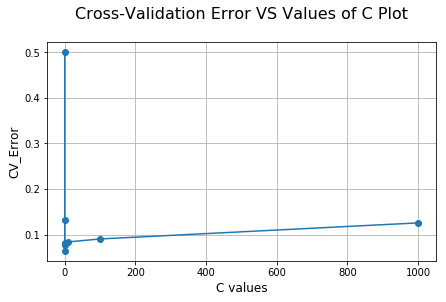

In [132]:
cv_errors = [1-i for i in model_tf_l1.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of TFIDF with L1 as follows: 

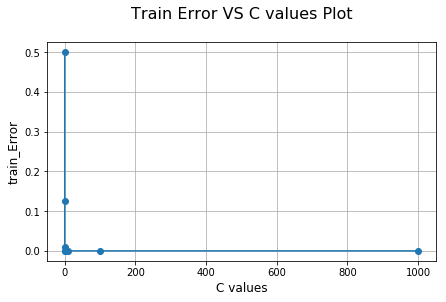

In [133]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_tf_l1.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [134]:
pred_train= model_tf_l1.predict(tf_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 6808,   122],
       [ 2424, 39646]], dtype=int64)

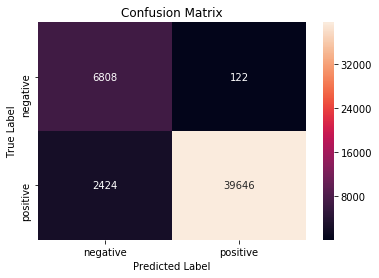

In [135]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of TFIDF with L1 Regularization

In [136]:
clf_tf_l1 = LogisticRegression(penalty = 'l1', C = 0.01,class_weight = 'balanced', n_jobs=-1)
clf_tf_l1.fit(tf_train1, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## ROC Curve of train data and test data on TFIDF with L1 as follows:

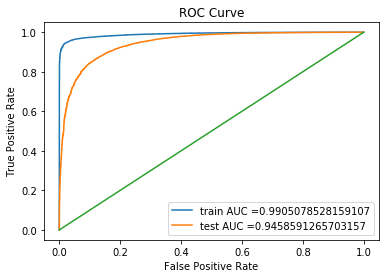

In [137]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tf_l1.predict_proba(tf_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tf_l1.predict_proba(tf_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [138]:
pred = clf_tf_l1.predict(tf_test1)
pred_prob = clf_tf_l1.predict_proba(tf_test1)[:,1]
pred_prob_train= clf_tf_l1.predict_proba(tf_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.9905078528159107
AUC value on test data: 0.9458591265703157


### Confusion Matrix of test data 

In [139]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4216,   933],
       [ 2171, 22680]], dtype=int64)

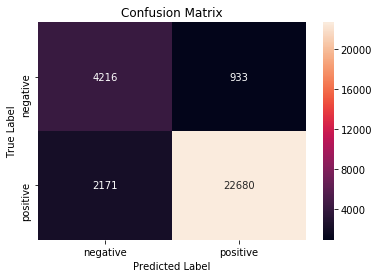

In [140]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [141]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.66      0.82      0.73      5149
          1       0.96      0.91      0.94     24851

avg / total       0.91      0.90      0.90     30000



### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

Hypertuning:

In [95]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_tf_l2=GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l2'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_tf_l2.fit(tf_train1,y_train)

print("AUC of Model", model_tf_l2.score(tf_cv1, y_cv))
print("Model with best parameters :\n",model_tf_l2.best_estimator_)
#Optimal value of C
optimal_C_tf_l2 = model_tf_l2.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_tf_l2)

AUC of Model 0.9427385838011018
Model with best parameters :
 LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  0.0001


# Graph representation of CV error v/s values of C on CV data of TFIDF with L2 as follows:

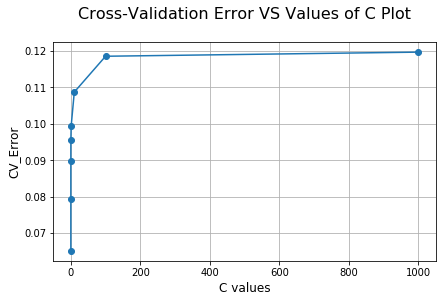

In [142]:
cv_errors = [1-i for i in model_tf_l2.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of TFIDF with L2 as follows:

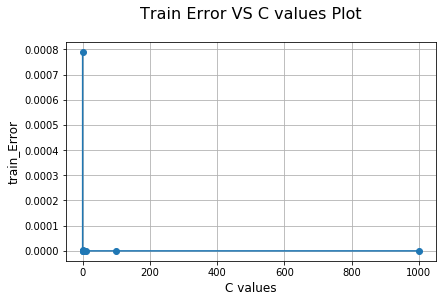

In [143]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_tf_l2.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [144]:
pred_train= model_tf_l2.predict(tf_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 6917,    13],
       [ 1286, 40784]], dtype=int64)

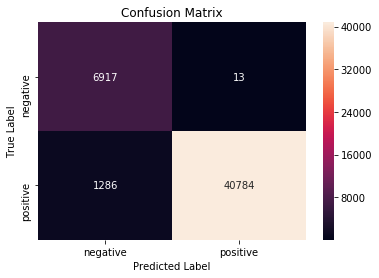

In [145]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of TFIDF with L2 Regularization

In [146]:
clf_tf_l2 = LogisticRegression(penalty = 'l2', C = 0.0001,class_weight = 'balanced', n_jobs=-1)
clf_tf_l2.fit(tf_train1, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## ROC Curve of train data and test data on TFIDF with L2 as follows:

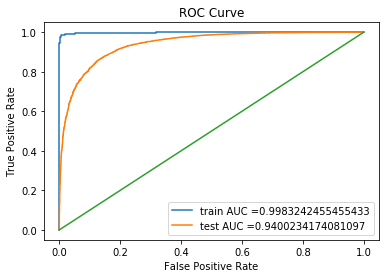

In [147]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tf_l2.predict_proba(tf_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tf_l2.predict_proba(tf_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [148]:
pred = clf_tf_l2.predict(tf_test1)
pred_prob = clf_tf_l2.predict_proba(tf_test1)[:,1]
pred_prob_train= clf_tf_l2.predict_proba(tf_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.9983242455455433
AUC value on test data: 0.9400234174081097


### Confusion Matrix of test data

In [149]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4019,  1130],
       [ 1801, 23050]], dtype=int64)

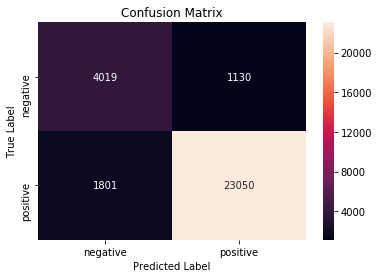

In [150]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [151]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.69      0.78      0.73      5149
          1       0.95      0.93      0.94     24851

avg / total       0.91      0.90      0.90     30000



### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of negative class and positive class from<font color='red'> SET 2</font>

In [159]:
def show_most_informative_features(vectorizer, clf_tf_l2, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf_tf_l2.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


show_most_informative_features(tfidf_vec,clf_tf_l2)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

		Negative					Positive
________________________________________________________________________________________________
	-0.0941	disappoint     				0.1012	great          
	-0.0579	worst          				0.0894	love           
	-0.0516	terribl        				0.0789	best           
	-0.0499	horribl        				0.0621	delici         
	-0.0478	aw             				0.0621	good           
	-0.0455	stale          				0.0533	perfect        
	-0.0454	wont buy       				0.0512	excel          
	-0.0446	threw          				0.0454	nice           
	-0.0443	return         				0.0431	high recommend 
	-0.0434	wast money     				0.0420	find           


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [91]:
sc = StandardScaler(with_mean=False)
avgw2v_train1 = sc.fit_transform(avgw2v_train)
avgw2v_cv1 = sc.transform(avgw2v_cv)
avgw2v_test1 = sc.transform(avgw2v_test)

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

Hypertuning:

In [96]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_w2v_l1=GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l1'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_w2v_l1.fit(avgw2v_train1,y_train)

print("AUC of Model", model_w2v_l1.score(avgw2v_cv1, y_cv))
print("Model with best parameters :\n",model_w2v_l1.best_estimator_)
#Optimal value of C
optimal_C_w2v_l1 = model_w2v_l1.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_w2v_l1)

AUC of Model 0.9023043296767194
Model with best parameters :
 LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  1


# Graph representation of CV error v/s values of C on CV data of AVGW2V with L1 as follows:

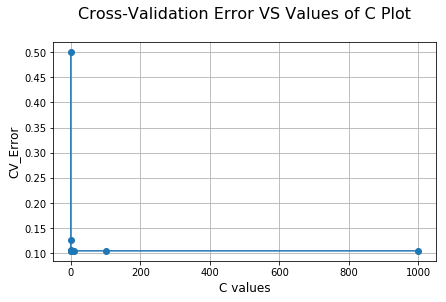

In [160]:
cv_errors = [1-i for i in model_w2v_l1.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of AVGW2V with L1 as follows:

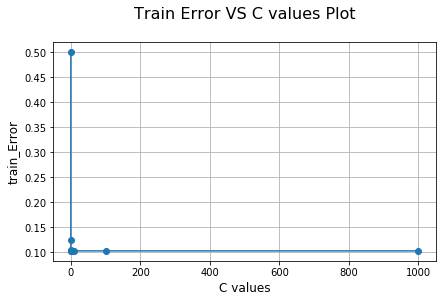

In [161]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_w2v_l1.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [162]:
pred_train= model_w2v_l1.predict(avgw2v_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 5784,  1146],
       [ 8343, 33727]], dtype=int64)

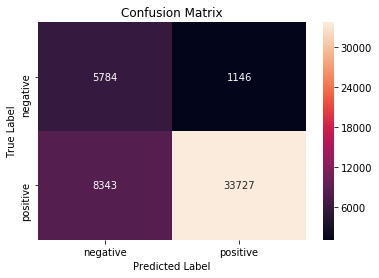

In [163]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of AVGW2V with L1 regularization

In [164]:
clf_w2v_l1 = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced', n_jobs=-1)
clf_w2v_l1.fit(avgw2v_train1, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# ROC Curve of train data and test data on AVGW2V with L1 as follows:

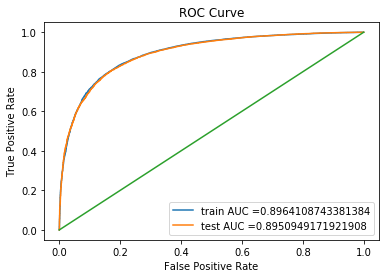

In [165]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_w2v_l1.predict_proba(avgw2v_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_w2v_l1.predict_proba(avgw2v_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [166]:
pred = clf_w2v_l1.predict(avgw2v_test1)
pred_prob = clf_w2v_l1.predict_proba(avgw2v_test1)[:,1]
pred_prob_train= clf_w2v_l1.predict_proba(avgw2v_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.8964108743381384
AUC value on test data: 0.8950949171921908


### Confusion Matrix of test data

In [167]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4404,   745],
       [ 5576, 19275]], dtype=int64)

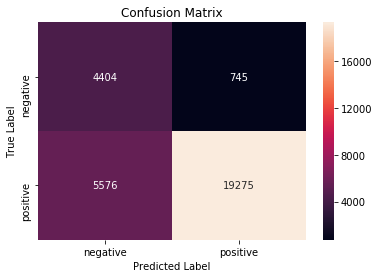

In [168]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [169]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.44      0.86      0.58      5149
          1       0.96      0.78      0.86     24851

avg / total       0.87      0.79      0.81     30000



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

Hypertuning:

In [97]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_w2v_l2=GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l2'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_w2v_l2.fit(avgw2v_train1,y_train)

print("AUC of Model", model_w2v_l2.score(avgw2v_cv1, y_cv))
print("Model with best parameters :\n",model_w2v_l2.best_estimator_)
#Optimal value of C
optimal_C_w2v_l2 = model_w2v_l2.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_w2v_l2)

AUC of Model 0.9023058212622763
Model with best parameters :
 LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  1


# Graph representation of CV error v/s values of C on CV data of AVGW2V with L2 as follows:

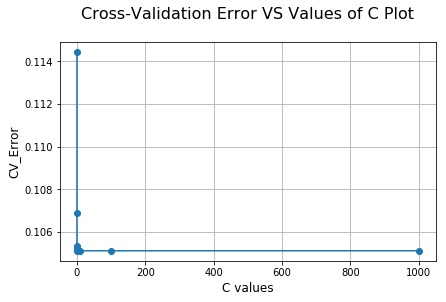

In [170]:
cv_errors = [1-i for i in model_w2v_l2.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

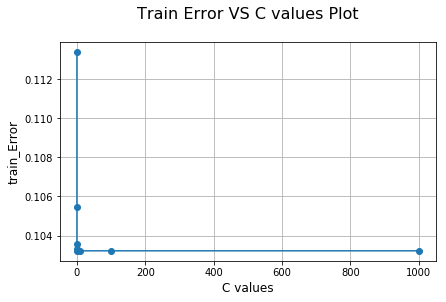

In [171]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_w2v_l2.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [172]:
pred_train= model_w2v_l2.predict(avgw2v_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 5785,  1145],
       [ 8338, 33732]], dtype=int64)

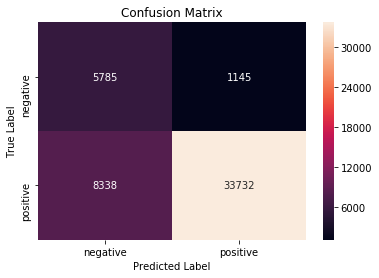

In [173]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of AVGW2V with L2 regularization

In [174]:
clf_w2v_l2 = LogisticRegression(penalty = 'l2', C = 1,class_weight = 'balanced', n_jobs=-1)
clf_w2v_l2.fit(avgw2v_train1, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# ROC Curve of train data and test data on AVGW2V with L2 as follows:

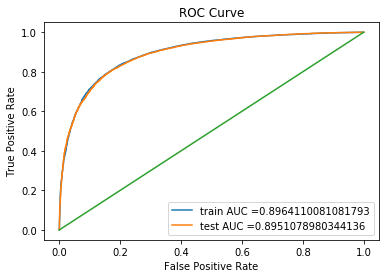

In [175]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_w2v_l2.predict_proba(avgw2v_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_w2v_l2.predict_proba(avgw2v_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1])
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [176]:
pred = clf_w2v_l2.predict(avgw2v_test1)
pred_prob = clf_w2v_l2.predict_proba(avgw2v_test1)[:,1]
pred_prob_train= clf_w2v_l2.predict_proba(avgw2v_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.8964110081081793
AUC value on test data: 0.8951078980344136


### Confusion Matrix of test data

In [177]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 4404,   745],
       [ 5577, 19274]], dtype=int64)

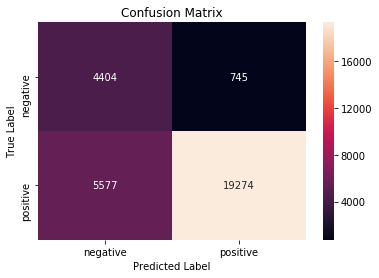

In [178]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [179]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.44      0.86      0.58      5149
          1       0.96      0.78      0.86     24851

avg / total       0.87      0.79      0.81     30000



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [92]:
sc = StandardScaler(with_mean=False)
tfw2v_train1 = sc.fit_transform(tfw2v_train)
tfw2v_cv1 = sc.transform(tfw2v_cv)
tfw2v_test1 = sc.transform(tfw2v_test)

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Hypertuning:

In [98]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_tfw2v_l1=GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l1'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_tfw2v_l1.fit(tfw2v_train1,y_train)

print("AUC of Model", model_tfw2v_l1.score(tfw2v_cv1, y_cv))
print("Model with best parameters :\n",model_tfw2v_l1.best_estimator_)
#Optimal value of C
optimal_C_tfw2v_l1 = model_tfw2v_l1.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_tfw2v_l1)

AUC of Model 0.508407153586592
Model with best parameters :
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  0.01


# Graph representation of CV error v/s values of C on CV data of TFIDFW2V with L1 as follows: 

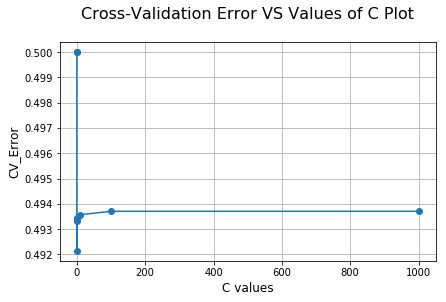

In [180]:
cv_errors = [1-i for i in model_tfw2v_l1.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of TFIDFW2V with L1 as follows:

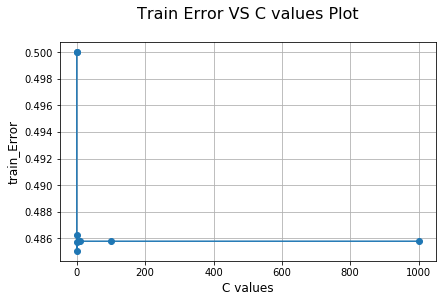

In [181]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_tfw2v_l1.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [182]:
pred_train= model_tfw2v_l1.predict(tfw2v_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[ 6753,   177],
       [40581,  1489]], dtype=int64)

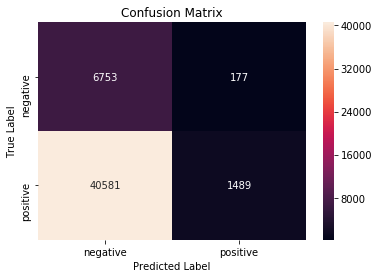

In [183]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of TFIDF-W2V with L1 regularization

In [184]:
clf_tfw2v_l1 = LogisticRegression(penalty = 'l1', C = 0.01,class_weight = 'balanced', n_jobs=-1)
clf_tfw2v_l1.fit(tfw2v_train1, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# ROC Curve of train data and test data on TFIDFW2V with L1 as follows:

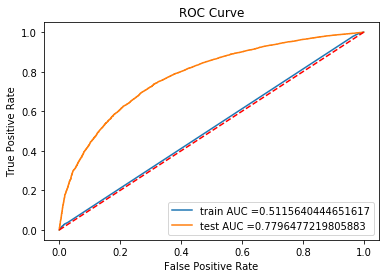

In [186]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tfw2v_l1.predict_proba(tfw2v_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tfw2v_l1.predict_proba(tfw2v_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1], 'r--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [187]:
pred = clf_tfw2v_l1.predict(tfw2v_test1)
pred_prob = clf_tfw2v_l1.predict_proba(tfw2v_test1)[:,1]
pred_prob_train= clf_tfw2v_l1.predict_proba(tfw2v_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.5115640444651617
AUC value on test data: 0.7796477219805883


### Confusion Matrix of test data

In [188]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 3599,  1550],
       [ 6852, 17999]], dtype=int64)

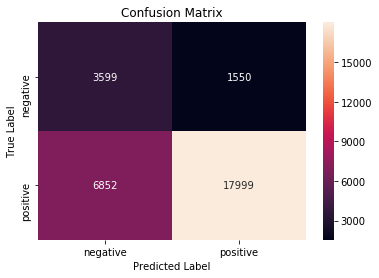

In [189]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [190]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.34      0.70      0.46      5149
          1       0.92      0.72      0.81     24851

avg / total       0.82      0.72      0.75     30000



### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

Hypertuning:

In [99]:
list_C=[10**-4, 10**-3,10**-2,10**-1,1,10,100,1000]
param = {'C' : list_C }
model_tfw2v_l2=GridSearchCV(LogisticRegression(class_weight = 'balanced',penalty='l2'),param ,scoring = 'roc_auc',cv = 3,n_jobs= -1)
model_tfw2v_l2.fit(tfw2v_train1,y_train)

print("AUC of Model", model_tfw2v_l2.score(tfw2v_cv1, y_cv))
print("Model with best parameters :\n",model_tfw2v_l2.best_estimator_)
#Optimal value of C
optimal_C_tfw2v_l2 = model_tfw2v_l2.best_estimator_.C
print("The optimal value of C(1/lamda) is : ",optimal_C_tfw2v_l2)

AUC of Model 0.5085891270245326
Model with best parameters :
 LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The optimal value of C(1/lamda) is :  0.0001


# Graph representation of CV error v/s values of C on CV data of TFIDFW2V with L2 as follows:

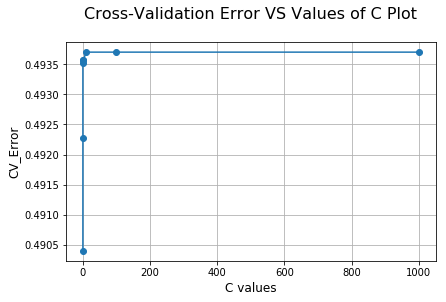

In [191]:
cv_errors = [1-i for i in model_tfw2v_l2.cv_results_['mean_test_score']]
# plotting Cross-Validation Error vs Base learners graph 
plt.plot(list_C, cv_errors, marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('CV_Error',size=12)
plt.title('Cross-Validation Error VS Values of C Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

# Graph representation of train error v/s values of C on train data of TFIDFW2V with L2 as follows:

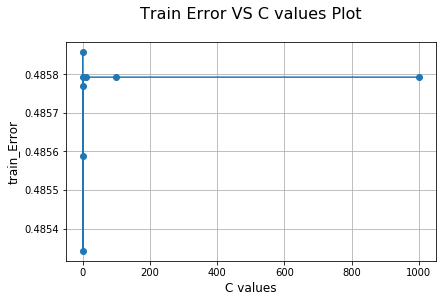

In [192]:
# Cross-Validation errors on train data
cv_errors1 = [1-i for i in model_tfw2v_l2.cv_results_['mean_train_score']]
# plotting Cross-Validation Error vs tuples of (max_depth,n_estimators) graph 
plt.plot(list_C, cv_errors1,marker='o')
plt.xlabel('C values',size=12)
plt.ylabel('train_Error',size=12)
plt.title('Train Error VS C values Plot\n',size=16)
plt.tight_layout(pad=0.0)
plt.grid()
plt.show()

### Confusion Matrix of train data

In [193]:
pred_train= model_tfw2v_l2.predict(tfw2v_train1)
cm = confusion_matrix(y_train, pred_train)
cm

array([[  337,  6593],
       [ 1373, 40697]], dtype=int64)

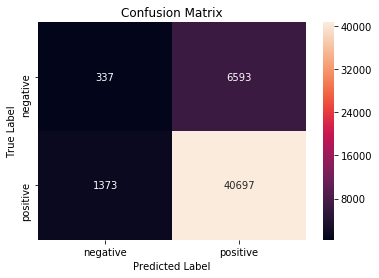

In [194]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Result on test data of TFIDF-W2V with L2 regularization

In [195]:
clf_tfw2v_l2 = LogisticRegression(penalty = 'l2', C = 0.0001,class_weight = 'balanced', n_jobs=-1)
clf_tfw2v_l2.fit(tfw2v_train1, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# ROC Curve of train data and test data on TFIDFW2V with L2 as follows:

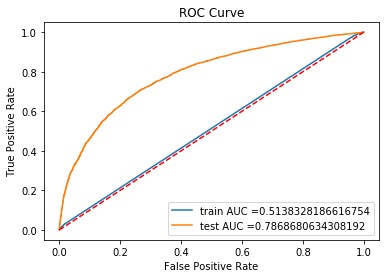

In [197]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_tfw2v_l2.predict_proba(tfw2v_train1)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_tfw2v_l2.predict_proba(tfw2v_test1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
#plt.scatter(train_fpr,train_tpr, label='train AUC')
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1], [0,1], 'r--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

In [198]:
pred = clf_tfw2v_l2.predict(tfw2v_test1)
pred_prob = clf_tfw2v_l2.predict_proba(tfw2v_test1)[:,1]
pred_prob_train= clf_tfw2v_l2.predict_proba(tfw2v_train1)[:,1]
print("AUC value on train data:",roc_auc_score(y_train, pred_prob_train))
print("AUC value on test data:",roc_auc_score(y_test, pred_prob))

AUC value on train data: 0.5138328186616754
AUC value on test data: 0.7868680634308192


### Confusion Matrix of test data

In [199]:
cm = confusion_matrix(y_test, pred)
cm

array([[ 3854,  1295],
       [ 7687, 17164]], dtype=int64)

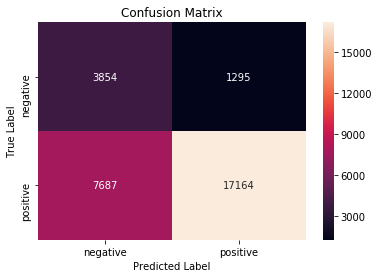

In [200]:
# plot confusion matrix to describe the performance of classifier.
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [201]:
# To show main classification report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.33      0.75      0.46      5149
          1       0.93      0.69      0.79     24851

avg / total       0.83      0.70      0.74     30000



# [6] Conclusions

In [203]:
from prettytable import PrettyTable
ptable = PrettyTable()

vec1 = "BOW"
vec2 = "TFIDF"
vec3 = "AVG-W2V"
vec4 = "TFIDF-W2V"

reg1= 'L1'
reg2='L2'

model1 = 'Logistic Regression'


ptable.field_names = ["Vectorizer","Model","Regularizer","Optimal C","Train AUC","Test AUC"]

ptable.add_row([vec1,model1,reg1,optimal_C,0.9763,0.9319])
ptable.add_row([vec1,model1,reg2,optimal_C_bow_l2,0.9882,0.9160])
ptable.add_row([vec2,model1,reg1,optimal_C_tf_l1,0.9905,0.9458])
ptable.add_row([vec2,model1,reg2,optimal_C_tf_l2,0.9983,0.9400])
ptable.add_row([vec3,model1,reg1,optimal_C_w2v_l1,0.8964,0.8950])
ptable.add_row([vec3,model1,reg2,optimal_C_w2v_l2,0.8964,0.8951])
ptable.add_row([vec4,model1,reg1,optimal_C_tfw2v_l1,0.5115,0.7796])
ptable.add_row([vec4,model1,reg2,optimal_C_tfw2v_l2,0.5138,0.7868])

print(ptable)

+------------+---------------------+-------------+-----------+-----------+----------+
| Vectorizer |        Model        | Regularizer | Optimal C | Train AUC | Test AUC |
+------------+---------------------+-------------+-----------+-----------+----------+
|    BOW     | Logistic Regression |      L1     |    0.01   |   0.9763  |  0.9319  |
|    BOW     | Logistic Regression |      L2     |   0.0001  |   0.9882  |  0.916   |
|   TFIDF    | Logistic Regression |      L1     |    0.01   |   0.9905  |  0.9458  |
|   TFIDF    | Logistic Regression |      L2     |   0.0001  |   0.9983  |   0.94   |
|  AVG-W2V   | Logistic Regression |      L1     |     1     |   0.8964  |  0.895   |
|  AVG-W2V   | Logistic Regression |      L2     |     1     |   0.8964  |  0.8951  |
| TFIDF-W2V  | Logistic Regression |      L1     |    0.01   |   0.5115  |  0.7796  |
| TFIDF-W2V  | Logistic Regression |      L2     |   0.0001  |   0.5138  |  0.7868  |
+------------+---------------------+-------------+----

From above observation, 
1) TFIDF with L1 and TFIDF with L2 both gives pretty good result.
2) The number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing). that means more sparsity by increasing lamda(decreasing C)